## **Import Dependencies**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils import to_categorical
from skimage import io
import csv
import os
from PIL import Image
import pandas as pd
import cv2
from IPython.display import Image
import pytesseract as pyt
import easyocr
from better_profanity import profanity

## Take photo

In [110]:
folder_path = "/Users/chae/Desktop/BigDataProj/input"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

cam = cv2.VideoCapture(0)
cv2.namedWindow("Clothing Recommendation Machine")
img_counter = 0

while True:
    ret, frame = cam.read()
    if not ret:
        print("failed to grab frame")
        break
    cv2.imshow("test", frame)
    k = cv2.waitKey(1)
    if k%256 == 27:
        print("Escape hit, closing...")
        break
    elif k%256 == 32:
        img_name = os.path.join(folder_path, "opencv_frame_{}.png".format(img_counter))
        cv2.imwrite(img_name, frame)
        print("Screenshot Taken")
        img_counter += 1

cam.release()
cv2.destroyAllWindows()


2024-05-05 18:57:10.931 Python[92737:795662] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


Escape hit, closing...


### Split train/test data from the FashionMNIST dataset on Kaggle (There were no other datasets)

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
train_indices = np.where(y_train != 8)
test_indices = np.where(y_test != 8)

x_train_filtered, y_train_filtered = x_train[train_indices], y_train[train_indices]
x_test_filtered, y_test_filtered = x_test[test_indices], y_test[test_indices]

x_train = x_train / 255
x_test = x_test / 255

## 8-Layer Model

In [14]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


## 4-Layer Model

In [5]:
model = tf.keras.models.Sequential([ tf.keras.layers.Flatten(input_shape=(28, 28, 1)), tf.keras.layers.Dense(128, activation='relu'), tf.keras.layers.Dense(10, activation='softmax') ])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
y_train_one_hot_filtered = to_categorical(y_train_filtered)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train_filtered, y_train_one_hot_filtered, epochs=10)


Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7298 - loss: 1.3172
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8625 - loss: 0.3702
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8748 - loss: 0.3298
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8846 - loss: 0.3080
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8927 - loss: 0.2826
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8987 - loss: 0.2685
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9062 - loss: 0.2508
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9106 - loss: 0.2343
Epoch 9/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9167 - loss: 0.2211
Epoch 10/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9189 - loss: 0.2154


## Run Clothing Segmentation (HuggingFace)

In [16]:
!python3 process.py --image '/Users/chae/Desktop/BigDataProj/input/opencv_frame_5.png'

Model already exists.
----checkpoints loaded from path: model/cloth_segm.pth----
[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.
/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


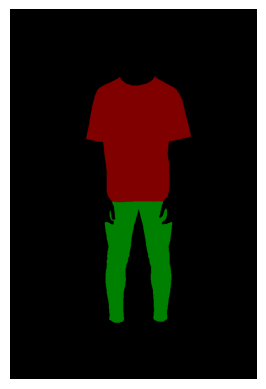

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('/Users/chae/Desktop/BigDataProj/output/cloth_seg/final_seg.png')

plt.imshow(img)
plt.axis('off')
plt.show()


## Image Processing

In [18]:
from PIL import Image
import os

def resize_image(image_path, target_size):
    image = Image.open(image_path)
    image = image.convert("L") 
    threshold = 200 
    image = image.point(lambda p: 255 - p if p < threshold else 0)
    image = image.resize(target_size)
    return image

def save_image(image, output_path):
    image.save(output_path)

def resize_images_in_directory(input_dir, output_dir, target_size):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            input_image_path = os.path.join(input_dir, filename)
            output_image_path = os.path.join(output_dir, filename)
            resized_image = resize_image(input_image_path, target_size)
            save_image(resized_image, output_image_path)
            print(f"Resized and saved {input_image_path} to {output_image_path}")

def main():
    input_dir = "output/alpha"
    output_dir = "rescaled_images" 
    target_size = (28, 28)
    resize_images_in_directory(input_dir, output_dir, target_size)
    print("All images resized and saved successfully!")

if __name__ == "__main__":
    main()


Resized and saved output/alpha/2.png to rescaled_images/2.png
Resized and saved output/alpha/1.png to rescaled_images/1.png
All images resized and saved successfully!


In [19]:
class_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

input_directory = "rescaled_images"
csv_path = "output_image_scikit.csv"
image_files = [f for f in os.listdir(input_directory) if f.endswith(('.png', '.jpg', '.jpeg'))]
pixels = []

for idx, image in enumerate(image_files, start=1):
    image_path = os.path.join(input_directory, image)
    img_gray = io.imread(image_path, as_gray=True)
    pixel_array = img_gray.flatten()
    # pixel_array = 255 - pixel_array
    pixels.append(np.concatenate(([image], pixel_array)))
    print(f"Converted image {idx}: {image}")

np.savetxt(csv_path, pixels, delimiter=',', fmt='%s')
print(f"CSV file saved at: {csv_path}")

test = pd.read_csv('output_image_scikit.csv', header=None, usecols=range(1, 785))
test = test.values
test = test.reshape(-1, 28, 28, 1)

predictions = []

for idx, row in enumerate(test):
    file_name = pixels[idx][0]
    prediction = model.predict(np.array([row]))
    predicted_class = np.argmax(prediction)
    predicted_class_name = class_names[predicted_class]
    print(f"File: {file_name}, Predicted class: {predicted_class_name}")
    predictions.append(predicted_class_name)


Converted image 1: 2.png
Converted image 2: 1.png
CSV file saved at: output_image_scikit.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
File: 2.png, Predicted class: Trouser
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
File: 1.png, Predicted class: Pullover


## Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
File: 2.png, Predicted class: Trouser


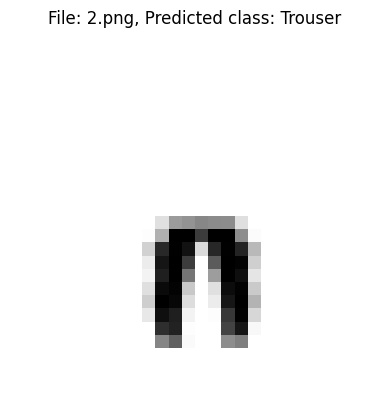

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
File: 1.png, Predicted class: Pullover


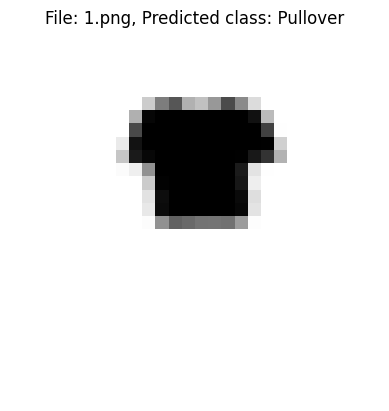

In [20]:
test = pd.read_csv('output_image_scikit.csv', header=None, usecols=range(1, 785))
test = test.values
test = test.reshape(-1, 28, 28, 1)
clothing_detected = False

for idx, row in enumerate(test):
    file_name = pixels[idx][0]  
    prediction = model.predict(np.array([row]))  
    predicted_class = np.argmax(prediction)  
    predicted_class_name = class_names[predicted_class]  

    # Check if either trousers or dress is detected
    if 'trousers' in predicted_class_name.lower() or 'dress' in predicted_class_name.lower():
        clothing_detected = True
    if 'T-shirt/top' in predicted_class_name.lower():
        clothing_detected = False
    
    image_data = row.reshape(28, 28)
    # Print the file name and predicted class
    print(f"File: {file_name}, Predicted class: {predicted_class_name}")  

    plt.imshow(image_data, cmap='gray')
    plt.title(f'File: {file_name}, Predicted class: {predicted_class_name}')
    plt.axis('off')
    plt.show()


## Image to Text

Using CPU. Note: This module is much faster with a GPU.


([[390, 172], [591, 172], [591, 235], [390, 235]], 'Standard', 0.9383788955052617)
([[385, 220], [590, 220], [590, 277], [385, 277]], 'Charterec', 0.956761284184468)


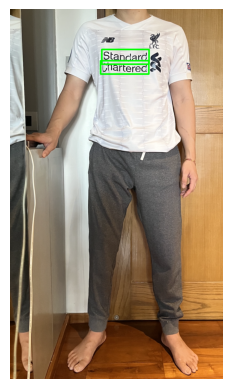

In [21]:
image_path = '/Users/chae/Desktop/BigDataProj/input/Screenshot 2024-05-05 at 17.24.21.png'
img = cv2.imread(image_path)

reader = easyocr.Reader(['en'], gpu=False)

text = reader.readtext(img)
store = []

for t in text:
    print(t)
    store.append(t)
    bbox, text, score = t
    pt1 = (int(bbox[0][0]), int(bbox[0][1]))
    pt2 = (int(bbox[2][0]), int(bbox[2][1]))
    cv2.rectangle(img, pt1, pt2, (0, 255, 0), 5)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


## Final Result

In [22]:
store_words = [entry[1] for entry in store]
combined_sentence = ' '.join(store_words)
words = combined_sentence.split()

if len(words) < 5 and clothing_detected:
    if profanity.contains_profanity(combined_sentence):
        print('Inappropriate Clothing')
    else:
        print('Suitable Clothing')
else:
    print('Inappropriate Clothing')


Inappropriate Clothing
